<a href="https://colab.research.google.com/github/JDinizfv/CAGED_project/blob/main/Projeto_CAGED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

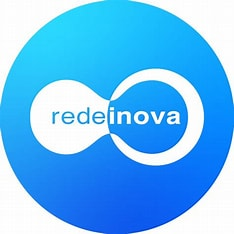

TESTE PARA VAGA DE ANALISTA DE BI (REDEINOVA)

Objetivos:

1. Acesse: ftp://ftp.mtps.gov.br/pdet/microdados/CAGED/  ou para entender melhor a base: http://pdet.mte.gov.br/microdados-rais-e-caged
2. Realize a Extração de dados de 2019 e 2018, filtre Capitais do Brasil. Informe o mecanismo optado pela extração e possíveis alternativas.
3. Realize o tratamento dos dados voltado para análise que será solicitado à frente que promova a melhor performance. Informe a ferramenta utilizada caso não seja o Power BI e apresente as etapas aplicadas.
4. Se achar necessário, crie um ambiente de armazenamento e detalhe a estrutura de tal solução é a ferramenta utilizada.
5. Construa um modelo relacional (ROLAP) no Power BI ou em SSAS.
6. Construa as métricas de Admitidos, Desligados e Saldo. Métricas adicionais podem ser incluídas conforme sua capacidade analítica julgar necessária, no máximo 4 adicionais se houver.
7. Avalie as métricas nas dimensões de: Capitais do Brasil, Região do Brasil, Atividade econômica e suas hierarquias, Atividade do empregado e período (horizonte temporal). Dimensões adicionais podem ser incluídas conforme sua capacidade analítica julgar necessária.
8. Apresente as análises propostas em um Dashboard de Power BI com até 3 páginas (desconsiderando capa e contracapa se houver). Utilize o máximo de recursos que achar necessário para enriquecer a análise e navegação.
9. Disponibilize o Dashboard preferencialmente em link público do Power BI e PBIX para Download.
10. Descreva a mecânica de atualização do relatório. Grave vídeo de demonstração se possível.


1 - ok

#1 - Importações de Pacotes

In [1]:
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 892.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.8/413.8 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 43.8 MB/s eta 0:00:00


In [10]:
!pip install pandas sqlalchemy pymysql

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 738.3 kB/s eta 0:00:00


In [11]:
import pandas as pd
from ftplib import FTP
import os
import zipfile
import requests
import py7zr
from tqdm import tqdm
import glob
from sqlalchemy import create_engine

# 2 - Funções

In [3]:
def download_arquivos_ftp(ftp, diretorio_remoto, diretorio_local, anos_desejados):
    # Lista os arquivos e diretórios no diretório remoto
    arquivos_remotos = ftp.nlst(diretorio_remoto)

    for item in arquivos_remotos:
        item_nome = os.path.basename(item)
        item_local = os.path.join(diretorio_local, item_nome)

        # Verifica se o item é um arquivo de interesse
        if '.' in item_nome and any(ano in item_nome for ano in anos_desejados):
            print(f'Baixando arquivo: {item_nome}')
            try:
                # Obtém o tamanho do arquivo para a barra de progresso
                tamanho_arquivo = ftp.size(item)
                with open(item_local, 'wb') as arquivo_local, tqdm(
                        total=tamanho_arquivo, desc=f'Arquivo {item_nome}', unit='B',
                        unit_scale=True) as barra_progresso:
                    ftp.retrbinary(f'RETR {item}', lambda dados: (
                        arquivo_local.write(dados), barra_progresso.update(len(dados))))
                print(f'Arquivo {item_nome} baixado com sucesso.')
            except Exception as e:
                print(f'Erro ao baixar arquivo {item_nome}: {e}')
        elif '.' not in item_nome:  # Se for um diretório
            print(f'Baixando diretório: {item_nome}')
            os.makedirs(item_local, exist_ok=True)
            # Adiciona um critério de parada para evitar loop infinito
            if item not in diretorio_local:
                download_arquivos_ftp(ftp, item, item_local, anos_desejados)
            print(f'Diretório {item_nome} baixado com sucesso.')

In [4]:
def extrair_arquivos_zip(diretorio_zip, diretorio_extracao):
    for ano in os.listdir(diretorio_zip):
        ano_path = os.path.join(diretorio_zip, ano)
        if os.path.isdir(ano_path):  # Verifica se é um diretório (ano)
            for item in os.listdir(ano_path):
                item_path = os.path.join(ano_path, item)
                if item.endswith('.zip'):
                    print(f'Extraindo arquivo: {item}')
                    with zipfile.ZipFile(item_path, 'r') as zip_ref:
                        zip_ref.extractall(diretorio_extracao)
                    print(f'Arquivo {item} extraído com sucesso.')

In [5]:
def extrair_arquivos_7z(diretorio_principal, diretorio_extracao):
    for ano in os.listdir(diretorio_principal):
        ano_path = os.path.join(diretorio_principal, ano)
        if os.path.isdir(ano_path):  # Verifica se é um diretório (ano)
            for mes in os.listdir(ano_path):
                mes_path = os.path.join(ano_path, mes)
                if mes.endswith('.7z'):
                    print(f'Extraindo arquivo: {mes}')
                    with py7zr.SevenZipFile(mes_path, mode='r') as zip_ref:
                        zip_ref.extractall(diretorio_extracao)
                    print(f'Arquivo {mes} extraído com sucesso.')

# 3 - Importando os dados

In [6]:

# Define as informações do servidor FTP
ftp_host = 'ftp.mtps.gov.br'

# Diretório remoto onde os arquivos estão localizados
ftp_dir = '/pdet/microdados/CAGED/'

In [7]:
# Conecte-se ao servidor FTP
ftp = FTP(ftp_host)
ftp.login()  # Conexão anônima

# Mude para o diretório correto no servidor FTP
ftp.cwd(ftp_dir)

'250 CWD command successful.'

In [8]:
# Lista os arquivos no diretório remoto
arquivos_remotos = ftp.nlst()

# Diretório local onde os arquivos serão salvos
diretorio_local = f'/content/CAGED'

# Garante que o diretório local exista
os.makedirs(diretorio_local, exist_ok=True)

In [9]:
# Anos desejados
anos_desejados = ['2018', '2019']

In [10]:
# Baixa os arquivos do diretório remoto correspondentes aos anos desejados
print('Iniciando o download...')
download_arquivos_ftp(ftp, ftp_dir, diretorio_local, anos_desejados)

# Fecha a conexão FTP
ftp.quit()

print('Download concluído.')


Iniciando o download...
Baixando diretório: 2007
Diretório 2007 baixado com sucesso.
Baixando diretório: 2008
Diretório 2008 baixado com sucesso.
Baixando diretório: 2009
Diretório 2009 baixado com sucesso.
Baixando diretório: 2010
Diretório 2010 baixado com sucesso.
Baixando diretório: 2011
Diretório 2011 baixado com sucesso.
Baixando diretório: 2012
Diretório 2012 baixado com sucesso.
Baixando diretório: 2013
Diretório 2013 baixado com sucesso.
Baixando diretório: 2014
Diretório 2014 baixado com sucesso.
Baixando diretório: 2015
Diretório 2015 baixado com sucesso.
Baixando diretório: 2016
Diretório 2016 baixado com sucesso.
Baixando diretório: 2017
Diretório 2017 baixado com sucesso.
Baixando diretório: 2018
Baixando arquivo: CAGEDEST_012018.7z


Arquivo CAGEDEST_012018.7z: 100%|██████████| 25.2M/25.2M [00:33<00:00, 744kB/s]


Arquivo CAGEDEST_012018.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_022018.7z


Arquivo CAGEDEST_022018.7z: 100%|██████████| 23.3M/23.3M [00:30<00:00, 755kB/s]


Arquivo CAGEDEST_022018.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_032018.7z


Arquivo CAGEDEST_032018.7z: 100%|██████████| 24.6M/24.6M [00:32<00:00, 747kB/s]


Arquivo CAGEDEST_032018.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_042018.7z


Arquivo CAGEDEST_042018.7z: 100%|██████████| 23.4M/23.4M [00:30<00:00, 757kB/s]


Arquivo CAGEDEST_042018.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_052018.7z


Arquivo CAGEDEST_052018.7z: 100%|██████████| 26.0M/26.0M [00:51<00:00, 502kB/s]


Arquivo CAGEDEST_052018.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_062018.7z


Arquivo CAGEDEST_062018.7z: 100%|██████████| 24.2M/24.2M [00:33<00:00, 714kB/s]


Arquivo CAGEDEST_062018.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_072018.7z


Arquivo CAGEDEST_072018.7z: 100%|██████████| 24.6M/24.6M [00:33<00:00, 744kB/s]


Arquivo CAGEDEST_072018.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_082018.7z


Arquivo CAGEDEST_082018.7z: 100%|██████████| 24.5M/24.5M [00:32<00:00, 758kB/s]


Arquivo CAGEDEST_082018.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_092018.7z


Arquivo CAGEDEST_092018.7z: 100%|██████████| 22.0M/22.0M [00:30<00:00, 724kB/s]


Arquivo CAGEDEST_092018.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_102018.7z


Arquivo CAGEDEST_102018.7z: 100%|██████████| 23.5M/23.5M [00:31<00:00, 753kB/s]


Arquivo CAGEDEST_102018.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_112018.7z


Arquivo CAGEDEST_112018.7z: 100%|██████████| 21.8M/21.8M [00:29<00:00, 746kB/s]


Arquivo CAGEDEST_112018.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_122018.7z


Arquivo CAGEDEST_122018.7z: 100%|██████████| 20.9M/20.9M [00:27<00:00, 750kB/s]


Arquivo CAGEDEST_122018.7z baixado com sucesso.
Diretório 2018 baixado com sucesso.
Baixando diretório: 2019
Baixando arquivo: CAGEDEST_012019.7z


Arquivo CAGEDEST_012019.7z: 100%|██████████| 24.5M/24.5M [00:32<00:00, 755kB/s]


Arquivo CAGEDEST_012019.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_022019.7z


Arquivo CAGEDEST_022019.7z: 100%|██████████| 25.6M/25.6M [00:35<00:00, 716kB/s]


Arquivo CAGEDEST_022019.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_032019.7z


Arquivo CAGEDEST_032019.7z: 100%|██████████| 24.4M/24.4M [00:33<00:00, 721kB/s]


Arquivo CAGEDEST_032019.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_042019.7z


Arquivo CAGEDEST_042019.7z: 100%|██████████| 24.6M/24.6M [00:33<00:00, 734kB/s]


Arquivo CAGEDEST_042019.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_052019.7z


Arquivo CAGEDEST_052019.7z: 100%|██████████| 25.1M/25.1M [00:33<00:00, 753kB/s]


Arquivo CAGEDEST_052019.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_062019.7z


Arquivo CAGEDEST_062019.7z: 100%|██████████| 23.2M/23.2M [00:30<00:00, 749kB/s]


Arquivo CAGEDEST_062019.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_072019.7z


Arquivo CAGEDEST_072019.7z: 100%|██████████| 24.8M/24.8M [00:35<00:00, 703kB/s]


Arquivo CAGEDEST_072019.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_082019.7z


Arquivo CAGEDEST_082019.7z: 100%|██████████| 25.1M/25.1M [00:33<00:00, 743kB/s]


Arquivo CAGEDEST_082019.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_092019.7z


Arquivo CAGEDEST_092019.7z: 100%|██████████| 23.9M/23.9M [00:31<00:00, 756kB/s]


Arquivo CAGEDEST_092019.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_102019.7z


Arquivo CAGEDEST_102019.7z: 100%|██████████| 25.0M/25.0M [00:33<00:00, 737kB/s]


Arquivo CAGEDEST_102019.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_112019.7z


Arquivo CAGEDEST_112019.7z: 100%|██████████| 21.3M/21.3M [00:28<00:00, 741kB/s]


Arquivo CAGEDEST_112019.7z baixado com sucesso.
Baixando arquivo: CAGEDEST_122019.7z


Arquivo CAGEDEST_122019.7z: 100%|██████████| 19.6M/19.6M [00:28<00:00, 698kB/s]


Arquivo CAGEDEST_122019.7z baixado com sucesso.
Diretório 2019 baixado com sucesso.
Baixando diretório: EEC
Baixando diretório: 092018
Baixando diretório: SETOR
Baixando diretório: Brasil
Diretório Brasil baixado com sucesso.
Baixando diretório: MUN
Baixando diretório: AC
Diretório AC baixado com sucesso.
Baixando diretório: AL
Diretório AL baixado com sucesso.
Baixando diretório: AM
Diretório AM baixado com sucesso.
Baixando diretório: AP
Diretório AP baixado com sucesso.
Baixando diretório: BA
Diretório BA baixado com sucesso.
Baixando diretório: CE
Diretório CE baixado com sucesso.
Baixando diretório: DF
Diretório DF baixado com sucesso.
Baixando diretório: ES
Diretório ES baixado com sucesso.
Baixando diretório: FN
Diretório FN baixado com sucesso.
Baixando diretório: GB
Diretório GB baixado com sucesso.
Baixando diretório: GO
Diretório GO baixado com sucesso.
Baixando diretório: MA
Diretório MA baixado com sucesso.
Baixando diretório: MG
Diretório MG baixado com sucesso.
Baixando 

#4 - Extraindo os arquivos necessários

In [11]:
# Extrai arquivos zipados

# Diretório principal onde os arquivos 7z estão localizados
diretorio_principal = '/content/CAGED/'

# Diretório onde os arquivos serão extraídos
diretorio_extracao = '/content/Dados'

# Garante que o diretório de extração exista
os.makedirs(diretorio_extracao, exist_ok=True)

# Extrai os arquivos 7z de cada pasta de ano e mês dentro do diretório principal
extrair_arquivos_7z(diretorio_principal, diretorio_extracao)

print('Extração concluída.')

Extraindo arquivo: CAGEDEST_052018.7z
Arquivo CAGEDEST_052018.7z extraído com sucesso.
Extraindo arquivo: CAGEDEST_072018.7z
Arquivo CAGEDEST_072018.7z extraído com sucesso.
Extraindo arquivo: CAGEDEST_042018.7z
Arquivo CAGEDEST_042018.7z extraído com sucesso.
Extraindo arquivo: CAGEDEST_032018.7z
Arquivo CAGEDEST_032018.7z extraído com sucesso.
Extraindo arquivo: CAGEDEST_022018.7z
Arquivo CAGEDEST_022018.7z extraído com sucesso.
Extraindo arquivo: CAGEDEST_082018.7z
Arquivo CAGEDEST_082018.7z extraído com sucesso.
Extraindo arquivo: CAGEDEST_092018.7z
Arquivo CAGEDEST_092018.7z extraído com sucesso.
Extraindo arquivo: CAGEDEST_112018.7z
Arquivo CAGEDEST_112018.7z extraído com sucesso.
Extraindo arquivo: CAGEDEST_012018.7z
Arquivo CAGEDEST_012018.7z extraído com sucesso.
Extraindo arquivo: CAGEDEST_102018.7z
Arquivo CAGEDEST_102018.7z extraído com sucesso.
Extraindo arquivo: CAGEDEST_062018.7z
Arquivo CAGEDEST_062018.7z extraído com sucesso.
Extraindo arquivo: CAGEDEST_122018.7z
Arqui

#5 - Análise Exploratória

In [12]:
# Tentando ler o arquivo com codificação ISO-8859-1
teste = pd.read_csv('/content/Dados/CAGEDEST_012018.txt', sep=';', encoding='iso-8859-1')


<ipython-input-12-7db4bc5b359c>:2: DtypeWarning: Columns (32,33,34,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  teste = pd.read_csv('/content/Dados/CAGEDEST_012018.txt', sep=';', encoding='iso-8859-1')


In [13]:
teste.head()

,Admitidos/Desligados,Competência Declarada,Município,Ano Declarado,CBO 2002 Ocupação,CNAE 1.0 Classe,CNAE 2.0 Classe,CNAE 2.0 Subclas,Faixa Empr Início Jan,Grau Instrução,...,Microrregião,Região Adm RJ,Região Adm SP,Região Corede,Região Corede 04,Região Gov SP,Região Senac PR,Região Senai PR,Região Senai SP,Sub-Região Senai PR
0,2,201801,110004,2018,322415,85138,86305,8630504,2,8,...,11006,{ñ,999,{ñ,99,999,99,{ñ,999,99
1,2,201801,110011,2018,411030,1414,1512,151201,1,7,...,11004,{ñ,999,{ñ,99,999,99,{ñ,999,99
2,1,201801,110018,2018,142105,52442,47431,4743100,1,2,...,11007,{ñ,999,{ñ,99,999,99,{ñ,999,99
3,1,201801,110029,2018,914405,50415,45412,4541205,1,7,...,11006,{ñ,999,{ñ,99,999,99,{ñ,999,99
4,1,201801,110029,2018,914405,50415,45412,4541205,1,7,...,11006,{ñ,999,{ñ,99,999,99,{ñ,999,99


In [14]:
teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2491174 entries, 0 to 2491173
Data columns (total 40 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   Admitidos/Desligados   int64 
 1   Competência Declarada  int64 
 2   Município              int64 
 3   Ano Declarado          int64 
 4   CBO 2002 Ocupação      int64 
 5   CNAE 1.0 Classe        int64 
 6   CNAE 2.0 Classe        int64 
 7   CNAE 2.0 Subclas       int64 
 8   Faixa Empr Início Jan  int64 
 9   Grau Instrução         int64 
 10  Qtd Hora Contrat       int64 
 11  IBGE Subsetor          int64 
 12  Idade                  int64 
 13  Ind Aprendiz           int64 
 14  Ind Portador Defic     int64 
 15  Raça Cor               int64 
 16  Salário Mensal         object
 17  Saldo Mov              int64 
 18  Sexo                   int64 
 19  Tempo Emprego          object
 20  Tipo Estab             int64 
 21  Tipo Defic             int64 
 22  Tipo Mov Desagregado   int64 
 23  UF     

In [15]:
# Tentando ler o arquivo com codificação Windows-1252
teste2 = pd.read_csv('/content/Dados/CAGEDEST_012018.txt', sep=';', encoding='windows-1252')
teste2

<ipython-input-15-96fc59058c30>:2: DtypeWarning: Columns (32,33,34,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  teste2 = pd.read_csv('/content/Dados/CAGEDEST_012018.txt', sep=';', encoding='windows-1252')


,Admitidos/Desligados,Competência Declarada,Município,Ano Declarado,CBO 2002 Ocupação,CNAE 1.0 Classe,CNAE 2.0 Classe,CNAE 2.0 Subclas,Faixa Empr Início Jan,Grau Instrução,...,Microrregião,Região Adm RJ,Região Adm SP,Região Corede,Região Corede 04,Região Gov SP,Região Senac PR,Região Senai PR,Região Senai SP,Sub-Região Senai PR
0,2,201801,110004,2018,322415,85138,86305,8630504,2,8,...,11006,{ñ,999,{ñ,99,999,99,{ñ,999,99
1,2,201801,110011,2018,411030,1414,1512,151201,1,7,...,11004,{ñ,999,{ñ,99,999,99,{ñ,999,99
2,1,201801,110018,2018,142105,52442,47431,4743100,1,2,...,11007,{ñ,999,{ñ,99,999,99,{ñ,999,99
3,1,201801,110029,2018,914405,50415,45412,4541205,1,7,...,11006,{ñ,999,{ñ,99,999,99,{ñ,999,99
4,1,201801,110029,2018,914405,50415,45412,4541205,1,7,...,11006,{ñ,999,{ñ,99,999,99,{ñ,999,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2491169,2,201801,530010,2018,513610,55212,56112,5611201,3,7,...,53001,{ñ,999,{ñ,99,999,99,{ñ,999,99
2491170,2,201801,530010,2018,510135,55212,56112,5611201,3,7,...,53001,{ñ,999,{ñ,99,999,99,{ñ,999,99
2491171,2,201801,530010,2018,513415,55212,56112,5611201,3,7,...,53001,{ñ,999,{ñ,99,999,99,{ñ,999,99
2491172,1,201801,530010,2018,510135,55212,56112,5611201,3,7,...,53001,{ñ,999,{ñ,99,999,99,{ñ,999,99


# 6 - Criando novas tabelas

## 6.1 Municípios

In [16]:
# Lista de códigos e nomes dos municípios (apenas um exemplo, substitua com seus dados reais)
capitais = {
    '110004': 'Rio Branco',
    '150140': 'Belém',
    '310620': 'Belo Horizonte',
    '140010': 'Boa Vista',
    '530010': 'Brasília',
    '500270': 'Campo Grande',
    '510340': 'Cuiabá',
    '410690': 'Curitiba',
    '420540': 'Florianópolis',
    '230440': 'Fortaleza',
    '520870': 'Goiânia',
    '250750': 'João Pessoa',
    '160030': 'Macapá',
    '270430': 'Maceió',
    '130260': 'Manaus',
    '240810': 'Natal',
    '172100': 'Palmas',
    '431490': 'Porto Alegre',
    '110020': 'Porto Velho',
    '261160': 'Recife',
    '120040': 'Rio Branco',
    '330455': 'Rio de Janeiro',
    '292740': 'Salvador',
    '211130': 'São Luís',
    '355030': 'São Paulo',
    '221100': 'Teresina',
    '320530': 'Vitória'
}



In [17]:


# Link para download do arquivo CSV da tabela de municípios do IBGE
url_municipios = 'https://www.gov.br/receitafederal/dados/municipios.csv/@@download/file'

# Nome da pasta onde os arquivos serão salvos
folder_name = 'IBGE'

# Verificar se a pasta existe, caso contrário, criar
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f'Pasta "{folder_name}" criada com sucesso!')
else:
    print(f'A pasta "{folder_name}" já existe.')

# Caminho para a pasta IBGE no Google Colab
caminho_pasta = '/content/IBGE/'

# Nome do arquivo CSV que você deseja criar
nome_arquivo_csv = 'tabela_municipios.csv'

# Caminho completo para o arquivo CSV
caminho_arquivo_csv = caminho_pasta + nome_arquivo_csv

# Baixar o arquivo CSV da tabela de municípios do IBGE
response = requests.get(url_municipios)
with open(caminho_arquivo_csv, 'wb') as f:
    f.write(response.content)

print(f'Arquivo CSV "{nome_arquivo_csv}" baixado e salvo com sucesso em "{caminho_pasta}"')

Pasta "IBGE" criada com sucesso!
Arquivo CSV "tabela_municipios.csv" baixado e salvo com sucesso em "/content/IBGE/"


## 6.2 CBO 2002 Ocupação

In [18]:
# Captch exigido

cbo2002 = 'http://www.mtecbo.gov.br/cbosite/pages/downloads.jsf'

## 6.3 CNAE

In [19]:
# CNAE

CONCLA = 'https://concla.ibge.gov.br/agencia-sala-de-imprensa/classificacoes/download-concla/8265-download.html'



In [20]:
# Links para download dos arquivos CSV com informações sobre CNAEs
url_cnae_2_classes = 'https://concla.ibge.gov.br/images/concla/downloads/revisao2007/PropCNAE20/CNAE20_EstruturaDetalhada.xls'
url_cnae_2_subclasses = 'https://concla.ibge.gov.br/images/concla/downloads/revisao2007/PropCNAE20/CNAE20_Subclasses_EstruturaDetalhada.xls'
url_cnae_1 = 'https://concla.ibge.gov.br/images/concla/downloads/CNAE1.0.xls'

# Caminho para a pasta IBGE no Google Colab
caminho_pasta = '/content/IBGE/'

# Nome dos arquivos CSV que você deseja criar
nome_arquivo_cnae_2_classes = 'CNAE_2_classes.csv'
nome_arquivo_cnae_2_subclasses = 'CNAE_2_subclasses.csv'
nome_arquivo_cnae_1 = 'CNAE_1.csv'

# Caminhos completos para os arquivos CSV
caminho_arquivo_cnae_2_classes = caminho_pasta + nome_arquivo_cnae_2_classes
caminho_arquivo_cnae_2_subclasses = caminho_pasta + nome_arquivo_cnae_2_subclasses
caminho_arquivo_cnae_1 = caminho_pasta + nome_arquivo_cnae_1

# Baixar os arquivos CSV com informações sobre CNAEs
response_cnae_2_classes = requests.get(url_cnae_2_classes)
with open(caminho_arquivo_cnae_2_classes, 'wb') as f:
    f.write(response_cnae_2_classes.content)

response_cnae_2_subclasses = requests.get(url_cnae_2_subclasses)
with open(caminho_arquivo_cnae_2_subclasses, 'wb') as f:
    f.write(response_cnae_2_subclasses.content)

response_cnae_1 = requests.get(url_cnae_1)
with open(caminho_arquivo_cnae_1, 'wb') as f:
    f.write(response_cnae_1.content)

print('Arquivos CSV baixados e salvos com sucesso na pasta IBGE.')

Arquivos CSV baixados e salvos com sucesso na pasta IBGE.


##6.4 Grau de instrução

In [21]:

# Dados completos para grau de instrução do IBGE
data = {
    'Código': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Descrição': [
        'Sem instrução e menos de 1 ano de estudo',
        '1 a 3 anos de estudo fundamental incompleto ou EJA',
        '4 a 7 anos de estudo fundamental incompleto ou EJA',
        'Fundamental completo',
        'Médio incompleto',
        'Médio completo',
        'Superior incompleto',
        'Superior completo',
        'Mestrado',
        'Doutorado'
    ]
}

# Criar o DataFrame
df_grau_instrucao = pd.DataFrame(data)

# Exibir o DataFrame
print(df_grau_instrucao)

# Nome da pasta onde os arquivos serão salvos
folder_name = 'IBGE'

# Verificar se a pasta existe, caso contrário, criar
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f'Pasta "{folder_name}" criada com sucesso!')
else:
    print(f'A pasta "{folder_name}" já existe.')

# Caminho completo para salvar o arquivo CSV
file_path = os.path.join(folder_name, 'grau_instrucao.csv')

# Salvar o DataFrame como CSV
df_grau_instrucao.to_csv(file_path, index=False)
print(f'Arquivo salvo em: {file_path}')


   Código                                          Descrição
0       1           Sem instrução e menos de 1 ano de estudo
1       2  1 a 3 anos de estudo fundamental incompleto ou...
2       3  4 a 7 anos de estudo fundamental incompleto ou...
3       4                               Fundamental completo
4       5                                   Médio incompleto
5       6                                     Médio completo
6       7                                Superior incompleto
7       8                                  Superior completo
8       9                                           Mestrado
9      10                                          Doutorado
A pasta "IBGE" já existe.
Arquivo salvo em: IBGE/grau_instrucao.csv


## 6.5 IBGE Subsetor

In [22]:
# Dados fornecidos
data = {
    'Código': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
    'Categoria': [
        'EXTR MINERAL', 'MIN NAO MET', 'IND METAL', 'IND MECANICA', 'ELET E COMUN',
        'MAT TRANSP', 'MAD E MOBIL', 'PAPEL E GRAF', 'BOR FUN COUR', 'IND QUIMICA',
        'IND TEXTIL', 'IND CALCADOS', 'ALIM E BEB', 'SERV UTIL PUB', 'CONSTR CIVIL',
        'COM VAREJ', 'COM ATACAD', 'INST FINANC', 'ADM TEC PROF', 'TRAN E COMUN',
        'ALOJ COMUNIC', 'MED ODON VET', 'ENSINO', 'ADM PUBLICA', 'AGRICULTURA', 'OUTROS'
    ],
    'Descrição': [
        'EXTRACAO DE MINERAIS', 'INDUSTRIA DE PRODUTOS MINERAIS NAO METALICOS', 'INDUSTRIA METALURGICA',
        'INDUSTRIA MECANICA', 'INDUSTRIA DO MATERIAL ELETRICO E DE COMUNICACOES',
        'INDUSTRIA DO MATERIAL DE TRANSPORTE', 'INDUSTRIA DA MADEIRA E DO MOBILIARIO',
        'INDUSTRIA DO PAPEL, PAPELAO, EDITORIAL E GRAFICA',
        'IND. DA BORRACHA, DO FUMO, DE COUROS, PELES E PROD. SIMIL. E IND. DIV.',
        'IND. QUIM., DE PROD. FARM., VETER., DE PERF., SABOES, VELAS E MAT. PLA',
        'INDUSTRIA TEXTIL, DO VESTUARIO E ARTEFATOS DE TECIDOS', 'INDUSTRIA DE CALCADOS',
        'INDUSTRIA DE PROD. ALIMENTICIOS, DE BEBIDAS E ALCOOL ETILICO.',
        'SERVICOS INDUSTRIAIS DE UTILIDADE PUBLICA', 'CONSTRUCAO CIVIL', 'COMERCIO VAREJISTA',
        'COMERCIO ATACADISTA', 'INSTITUICOES DE CREDITO, SEGUROS E DE CAPITALIZACAO',
        'COM,ADM.IMOV,VAL.MOB,SERV.TECN-PROF,AUX.ATIV.ECON E ORG.INT E REP. INT',
        'TRANSPORTE E COMUNICACOES',
        'SERV.ALOJ, ALIM,REP,MANUT,RES, DOMIC,DIVERS,RADIO DIF,TV,COM ESOC',
        'SERVICOS MEDICOS, ODONTOLOGICOS E VETERINARIOS', 'ENSINO', 'ADM. PUBLICA DIRETA E AUTARQUICA',
        'AGRIC., SILVICULTURA, CRIACAO DE ANIM., EXTR.VEG., PESCA E AGRICULTURA', 'OUTROS'
    ]
}

# Criar o DataFrame
df_subsetor = pd.DataFrame(data)

# Exibir o DataFrame
print(df_subsetor)

# Nome da pasta onde os arquivos serão salvos
folder_name = 'IBGE'

# Verificar se a pasta existe, caso contrário, criar
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f'Pasta "{folder_name}" criada com sucesso!')
else:
    print(f'A pasta "{folder_name}" já existe.')

# Caminho completo para salvar o arquivo CSV
file_path = os.path.join(folder_name, 'subsetor.csv')

# Salvar o DataFrame como CSV
df_subsetor.to_csv(file_path, index=False)
print(f'Arquivo salvo em: {file_path}')

    Código      Categoria                                          Descrição
0        1   EXTR MINERAL                               EXTRACAO DE MINERAIS
1        2    MIN NAO MET       INDUSTRIA DE PRODUTOS MINERAIS NAO METALICOS
2        3      IND METAL                              INDUSTRIA METALURGICA
3        4   IND MECANICA                                 INDUSTRIA MECANICA
4        5   ELET E COMUN   INDUSTRIA DO MATERIAL ELETRICO E DE COMUNICACOES
5        6     MAT TRANSP                INDUSTRIA DO MATERIAL DE TRANSPORTE
6        7    MAD E MOBIL               INDUSTRIA DA MADEIRA E DO MOBILIARIO
7        8   PAPEL E GRAF   INDUSTRIA DO PAPEL, PAPELAO, EDITORIAL E GRAFICA
8        9   BOR FUN COUR  IND. DA BORRACHA, DO FUMO, DE COUROS, PELES E ...
9       10    IND QUIMICA  IND. QUIM., DE PROD. FARM., VETER., DE PERF., ...
10      11     IND TEXTIL  INDUSTRIA TEXTIL, DO VESTUARIO E ARTEFATOS DE ...
11      12   IND CALCADOS                              INDUSTRIA DE CALCADOS

## 6.6 Raça/Cor

In [23]:

# Dados de raça/cor segundo o IBGE
data_raca_cor = {
    'Código': [1, 2, 3, 4, 5, 9],
    'Descrição': ['Branca', 'Preta', 'Amarela', 'Parda', 'Indígena', 'Sem declaração']
}

# Criar o DataFrame
df_raca_cor = pd.DataFrame(data_raca_cor)

# Exibir o DataFrame
print(df_raca_cor)

# Nome da pasta onde os arquivos serão salvos
folder_name = 'IBGE'

# Verificar se a pasta existe, caso contrário, criar
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f'Pasta "{folder_name}" criada com sucesso!')
else:
    print(f'A pasta "{folder_name}" já existe.')

# Caminho completo para salvar o arquivo CSV
file_path = os.path.join(folder_name, 'raca_cor.csv')

# Salvar o DataFrame como CSV
df_raca_cor.to_csv(file_path, index=False)
print(f'Arquivo salvo em: {file_path}')


   Código       Descrição
0       1          Branca
1       2           Preta
2       3         Amarela
3       4           Parda
4       5        Indígena
5       9  Sem declaração
A pasta "IBGE" já existe.
Arquivo salvo em: IBGE/raca_cor.csv


## 6.7 Faixa empregados no inicio de janeiro

In [24]:

# Exemplo de dados fictícios de faixa de empregados no início de janeiro
data_faixa_emp = {
    'Código': [1, 2, 3, 4, 5, 6],
    'Faixa de Empregados': ['0 - 9', '10 - 49', '50 - 99', '100 - 499', '500 - 999', '1000 ou mais']
}

# Criar o DataFrame
df_faixa_emp = pd.DataFrame(data_faixa_emp)

# Exibir o DataFrame
print(df_faixa_emp)

# Nome da pasta onde os arquivos serão salvos
folder_name = 'IBGE'

# Verificar se a pasta existe, caso contrário, criar
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f'Pasta "{folder_name}" criada com sucesso!')
else:
    print(f'A pasta "{folder_name}" já existe.')

# Caminho completo para salvar o arquivo CSV
file_path = os.path.join(folder_name, 'faixa_emp_inic_jan.csv')

# Salvar o DataFrame como CSV
df_faixa_emp.to_csv(file_path, index=False)
print(f'Arquivo salvo em: {file_path}')


   Código Faixa de Empregados
0       1               0 - 9
1       2             10 - 49
2       3             50 - 99
3       4           100 - 499
4       5           500 - 999
5       6        1000 ou mais
A pasta "IBGE" já existe.
Arquivo salvo em: IBGE/faixa_emp_inic_jan.csv


## 6.8 Unidades da Federação

In [25]:
import pandas as pd

# Dados das UFs
dados_uf = {
    'Código': [11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 35, 41, 42, 43, 50, 51, 52, 53],
    'UF': ['RO', 'AC', 'AM', 'RR', 'PA', 'AP', 'TO', 'MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA', 'MG', 'ES', 'RJ', 'SP', 'PR', 'SC', 'RS', 'MS', 'MT', 'GO', 'DF'],
    'Nome': ['Rondônia', 'Acre', 'Amazonas', 'Roraima', 'Pará', 'Amapá', 'Tocantins', 'Maranhão', 'Piauí', 'Ceará', 'Rio Grande do Norte', 'Paraíba', 'Pernambuco', 'Alagoas', 'Sergipe', 'Bahia', 'Minas Gerais', 'Espírito Santo', 'Rio de Janeiro', 'São Paulo', 'Paraná', 'Santa Catarina', 'Rio Grande do Sul', 'Mato Grosso do Sul', 'Mato Grosso', 'Goiás', 'Distrito Federal']
}

# Criar o DataFrame
df_dados_uf = pd.DataFrame(dados_uf)

# Exibir o DataFrame
print(df_dados_uf)

# Nome da pasta onde os arquivos serão salvos
folder_name = 'IBGE'

# Verificar se a pasta existe, caso contrário, criar
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f'Pasta "{folder_name}" criada com sucesso!')
else:
    print(f'A pasta "{folder_name}" já existe.')

# Caminho completo para salvar o arquivo CSV
file_path = os.path.join(folder_name, 'dados_uf.csv')

# Salvar o DataFrame como CSV
df_dados_uf.to_csv(file_path, index=False)
print(f'Arquivo salvo em: {file_path}')


    Código  UF                 Nome
0       11  RO             Rondônia
1       12  AC                 Acre
2       13  AM             Amazonas
3       14  RR              Roraima
4       15  PA                 Pará
5       16  AP                Amapá
6       17  TO            Tocantins
7       21  MA             Maranhão
8       22  PI                Piauí
9       23  CE                Ceará
10      24  RN  Rio Grande do Norte
11      25  PB              Paraíba
12      26  PE           Pernambuco
13      27  AL              Alagoas
14      28  SE              Sergipe
15      29  BA                Bahia
16      31  MG         Minas Gerais
17      32  ES       Espírito Santo
18      33  RJ       Rio de Janeiro
19      35  SP            São Paulo
20      41  PR               Paraná
21      42  SC       Santa Catarina
22      43  RS    Rio Grande do Sul
23      50  MS   Mato Grosso do Sul
24      51  MT          Mato Grosso
25      52  GO                Goiás
26      53  DF     Distrito 

#7 - Limpeza e tratamento dos dados




##7.1 Converter para CSV

In [38]:
# Converter para CSV

# Caminho dos arquivos TXT e destino dos arquivos CSV
caminho_dados = '/content/Dados'
caminho_destino = '/content/Dados_CSV'

# Verificar se a pasta de destino existe, senão criar
if not os.path.exists(caminho_destino):
    os.makedirs(caminho_destino)


In [39]:
# Converter todos os arquivos TXT para CSV
for arquivo_txt in os.listdir(caminho_dados):
    if arquivo_txt.endswith('.txt'):
        caminho_arquivo_txt = os.path.join(caminho_dados, arquivo_txt)
        nome_arquivo_csv = arquivo_txt.replace('.txt', '.csv')
        caminho_arquivo_csv = os.path.join(caminho_destino, nome_arquivo_csv)

        with open(caminho_arquivo_txt, 'r', encoding='iso-8859-1') as arquivo_txt:
            with open(caminho_arquivo_csv, 'w', encoding='utf-8') as arquivo_csv:
                for linha in arquivo_txt:
                    arquivo_csv.write(linha)

        print(f'Arquivo convertido: {nome_arquivo_csv}')

print('Todos os arquivos foram convertidos para CSV.')

Arquivo convertido: CAGEDEST_072018.csv
Arquivo convertido: CAGEDEST_122018.csv
Arquivo convertido: CAGEDEST_052019.csv
Arquivo convertido: CAGEDEST_062018.csv
Arquivo convertido: CAGEDEST_062019.csv
Arquivo convertido: CAGEDEST_112019.csv
Arquivo convertido: CAGEDEST_022019.csv
Arquivo convertido: CAGEDEST_022018.csv
Arquivo convertido: CAGEDEST_012019.csv
Arquivo convertido: CAGEDEST_122019.csv
Arquivo convertido: CAGEDEST_102018.csv
Arquivo convertido: CAGEDEST_092018.csv
Arquivo convertido: CAGEDEST_102019.csv
Arquivo convertido: CAGEDEST_042019.csv
Arquivo convertido: CAGEDEST_112018.csv
Arquivo convertido: CAGEDEST_072019.csv
Arquivo convertido: CAGEDEST_042018.csv
Arquivo convertido: CAGEDEST_082019.csv
Arquivo convertido: CAGEDEST_052018.csv
Arquivo convertido: CAGEDEST_012018.csv
Arquivo convertido: CAGEDEST_082018.csv
Arquivo convertido: CAGEDEST_032019.csv
Arquivo convertido: CAGEDEST_032018.csv
Arquivo convertido: CAGEDEST_092019.csv
Todos os arquivos foram convertidos para

In [40]:

# Caminho para o arquivo CSV
caminho_arquivo_csv = '/content/Dados_CSV/CAGEDEST_012018.csv'

# Leitura do arquivo CSV com separador ';' e codificação ISO-8859-1
df = pd.read_csv(caminho_arquivo_csv, sep=';', encoding='utf-8')

# Impressão das primeiras linhas do DataFrame
df.head()


<ipython-input-40-d51f5dace514>:5: DtypeWarning: Columns (32,33,34,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_arquivo_csv, sep=';', encoding='utf-8')


,Admitidos/Desligados,Competência Declarada,Município,Ano Declarado,CBO 2002 Ocupação,CNAE 1.0 Classe,CNAE 2.0 Classe,CNAE 2.0 Subclas,Faixa Empr Início Jan,Grau Instrução,...,Microrregião,Região Adm RJ,Região Adm SP,Região Corede,Região Corede 04,Região Gov SP,Região Senac PR,Região Senai PR,Região Senai SP,Sub-Região Senai PR
0,2,201801,110004,2018,322415,85138,86305,8630504,2,8,...,11006,{ñ,999,{ñ,99,999,99,{ñ,999,99
1,2,201801,110011,2018,411030,1414,1512,151201,1,7,...,11004,{ñ,999,{ñ,99,999,99,{ñ,999,99
2,1,201801,110018,2018,142105,52442,47431,4743100,1,2,...,11007,{ñ,999,{ñ,99,999,99,{ñ,999,99
3,1,201801,110029,2018,914405,50415,45412,4541205,1,7,...,11006,{ñ,999,{ñ,99,999,99,{ñ,999,99
4,1,201801,110029,2018,914405,50415,45412,4541205,1,7,...,11006,{ñ,999,{ñ,99,999,99,{ñ,999,99


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2491174 entries, 0 to 2491173
Data columns (total 40 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   Admitidos/Desligados   int64 
 1   Competência Declarada  int64 
 2   Município              int64 
 3   Ano Declarado          int64 
 4   CBO 2002 Ocupação      int64 
 5   CNAE 1.0 Classe        int64 
 6   CNAE 2.0 Classe        int64 
 7   CNAE 2.0 Subclas       int64 
 8   Faixa Empr Início Jan  int64 
 9   Grau Instrução         int64 
 10  Qtd Hora Contrat       int64 
 11  IBGE Subsetor          int64 
 12  Idade                  int64 
 13  Ind Aprendiz           int64 
 14  Ind Portador Defic     int64 
 15  Raça Cor               int64 
 16  Salário Mensal         object
 17  Saldo Mov              int64 
 18  Sexo                   int64 
 19  Tempo Emprego          object
 20  Tipo Estab             int64 
 21  Tipo Defic             int64 
 22  Tipo Mov Desagregado   int64 
 23  UF     

##7.2 Filtrar por Capitais e remoção de Colunas

In [42]:
# Definir o caminho da pasta com os CSVs
caminho_pasta = '/content/Dados_CSV'

# Lista de capitais (substitua 'lista_capitais' pelas suas capitais)
capitais = {
    110004: 'Rio Branco',
    150140: 'Belém',
    310620: 'Belo Horizonte',
    140010: 'Boa Vista',
    530010: 'Brasília',
    500270: 'Campo Grande',
    510340: 'Cuiabá',
    410690: 'Curitiba',
    420540: 'Florianópolis',
    230440: 'Fortaleza',
    520870: 'Goiânia',
    250750: 'João Pessoa',
    160030: 'Macapá',
    270430: 'Maceió',
    130260: 'Manaus',
    240810: 'Natal',
    172100: 'Palmas',
    431490: 'Porto Alegre',
    110020: 'Porto Velho',
    261160: 'Recife',
    120040: 'Rio Branco',
    330455: 'Rio de Janeiro',
    292740: 'Salvador',
    211130: 'São Luís',
    355030: 'São Paulo',
    221100: 'Teresina',
    320530: 'Vitória'
}
# Colunas indesejadas
colunas_indesejadas = [
    'Bairros SP', 'Bairros Fortaleza', 'Bairros RJ', 'Distritos SP',
    'Regiões Adm DF', 'Mesorregião', 'Microrregião', 'Região Adm RJ',
    'Região Adm SP', 'Região Corede', 'Região Corede 04', 'Região Gov SP',
    'Região Senac PR', 'Região Senai PR', 'Região Senai SP', 'Sub-Região Senai PR',
    'Ind Trab Parcial', 'Ind Trab Intermitente'
]

In [43]:

# Iterar pelos arquivos na pasta
for arquivo in os.listdir(caminho_pasta):
    if arquivo.endswith('.csv'):
        # Carregar o CSV
        df = pd.read_csv(os.path.join(caminho_pasta, arquivo), sep = ';' , encoding = 'utf-8')

        # Filtrar o DataFrame para incluir apenas as capitais
        df_capitais = df[df['Município'].isin(capitais.keys())]

        # Remover as colunas indesejadas e todas as colunas a partir da numeração 25
        colunas_a_remover = list(df_capitais.columns[24:])
        df_capitais = df_capitais.drop(columns=colunas_a_remover, errors='ignore')

        # Salvar o DataFrame filtrado no mesmo arquivo CSV (substituindo o original)
        df_capitais.to_csv(os.path.join(caminho_pasta, arquivo), index=False)

print('Processamento concluído.')

<ipython-input-43-db2dbe58f84a>:5: DtypeWarning: Columns (32,33,34,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(caminho_pasta, arquivo), sep = ';' , encoding = 'utf-8')
<ipython-input-43-db2dbe58f84a>:5: DtypeWarning: Columns (32,33,34,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(caminho_pasta, arquivo), sep = ';' , encoding = 'utf-8')
<ipython-input-43-db2dbe58f84a>:5: DtypeWarning: Columns (32,33,34,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(caminho_pasta, arquivo), sep = ';' , encoding = 'utf-8')
<ipython-input-43-db2dbe58f84a>:5: DtypeWarning: Columns (32,33,34,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(caminho_pasta, arquivo), sep = ';' , encoding = 'utf-8')
<ipython-input-4

Processamento concluído.


In [49]:
# Caminho para o arquivo CSV
caminho_arquivo_csv = '/content/Dados_CSV/CAGEDEST_012018.csv'

# Leitura do arquivo CSV com separador ';' e codificação ISO-8859-1
df = pd.read_csv(caminho_arquivo_csv, sep=',')

# Impressão das primeiras linhas do DataFrame
df.head()


,Admitidos/Desligados,Competência Declarada,Município,Ano Declarado,CBO 2002 Ocupação,CNAE 1.0 Classe,CNAE 2.0 Classe,CNAE 2.0 Subclas,Faixa Empr Início Jan,Grau Instrução,...,Ind Portador Defic,Raça Cor,Salário Mensal,Saldo Mov,Sexo,Tempo Emprego,Tipo Estab,Tipo Defic,Tipo Mov Desagregado,UF
0,2,201801,110004,2018,322415,85138,86305,8630504,2,8,...,0,2,"000520,00",-1,2,"0005,0",1,0,6,11
1,1,201801,110004,2018,514320,52493,47890,4789004,1,7,...,0,4,"001085,00",1,2,"0000,0",1,0,2,11
2,1,201801,110020,2018,623110,1414,1512,151201,1,4,...,0,9,"001650,00",1,1,"0000,0",3,0,1,11
3,1,201801,110020,2018,411005,63126,52117,5211799,1,8,...,0,2,"002156,00",1,1,"0000,0",1,0,2,11
4,1,201801,110020,2018,717020,52442,47423,4742300,1,7,...,0,2,"001153,00",1,1,"0000,0",1,0,1,11


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843996 entries, 0 to 843995
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Admitidos/Desligados   843996 non-null  int64 
 1   Competência Declarada  843996 non-null  int64 
 2   Município              843996 non-null  int64 
 3   Ano Declarado          843996 non-null  int64 
 4   CBO 2002 Ocupação      843996 non-null  int64 
 5   CNAE 1.0 Classe        843996 non-null  int64 
 6   CNAE 2.0 Classe        843996 non-null  int64 
 7   CNAE 2.0 Subclas       843996 non-null  int64 
 8   Faixa Empr Início Jan  843996 non-null  int64 
 9   Grau Instrução         843996 non-null  int64 
 10  Qtd Hora Contrat       843996 non-null  int64 
 11  IBGE Subsetor          843996 non-null  int64 
 12  Idade                  843996 non-null  int64 
 13  Ind Aprendiz           843996 non-null  int64 
 14  Ind Portador Defic     843996 non-null  int64 
 15  

##7.2 Concatenar arquivos CSV da CAGED

In [2]:

# Diretório onde estão os arquivos CSV
csv_dir = '/content/Dados_CSV'  # Mude para o caminho onde seus CSVs estão armazenados

# Encontra todos os arquivos CSV no diretório
csv_files = glob.glob(os.path.join(csv_dir, '*.csv'))

# Lista para armazenar os DataFrames
dataframes = []


In [3]:
# Percorre todos os arquivos CSV encontrados
for file in csv_files:
    print(f"Lendo o arquivo: {file}")
    df = pd.read_csv(file, sep=',', encoding='utf-8')

    dataframes.append(df)

# Combina todos os DataFrames, alinhando as colunas por nome
print("Combinando todos os DataFrames...")
combined_df = pd.concat(dataframes, ignore_index=True, sort=False)

# Salva o DataFrame combinado em um novo arquivo CSV
output_file = '/content/combined_data.csv'
print(f"Salvando o DataFrame combinado no arquivo: {output_file}")
combined_df.to_csv(output_file, index=False, sep=';', encoding='utf-8')

print("Processamento concluído.")

Lendo o arquivo: /content/Dados_CSV/CAGEDEST_022019.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_092018.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_112018.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_052018.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_032018.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_032019.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_052019.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_062019.csv


<ipython-input-3-3657630f166f>:4: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, sep=',', encoding='utf-8')


Lendo o arquivo: /content/Dados_CSV/CAGEDEST_072019.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_022018.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_012018.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_092019.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_082018.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_122018.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_062018.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_102019.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_072018.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_042018.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_012019.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_112019.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_082019.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_122019.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_042019.csv
Lendo o arquivo: /content/Dados_CSV/CAGEDEST_102018.csv
Combinando todos os DataFrames...
Salvando o DataFrame combinado no arquivo: /content/combined_data.csv


In [4]:
combined_df.head()

,Admitidos/Desligados,Competência Declarada,Município,Ano Declarado,CBO 2002 Ocupação,CNAE 1.0 Classe,CNAE 2.0 Classe,CNAE 2.0 Subclas,Faixa Empr Início Jan,Grau Instrução,...,Ind Portador Defic,Raça Cor,Salário Mensal,Saldo Mov,Sexo,Tempo Emprego,Tipo Estab,Tipo Defic,Tipo Mov Desagregado,UF
0,1,201902,510340,2019,623115,1414,1512,151202,4,6,...,0,9,"001200,00",1,1,"0000,0",3,0,1,51
1,1,201902,510340,2019,622020,1414,1512,151201,6,6,...,0,8,"001150,00",1,1,"0000,0",1,0,1,51
2,1,201902,510340,2019,622020,5126,3221,322101,3,7,...,0,2,"001207,00",1,2,"0000,0",1,0,1,51
3,1,201902,510340,2019,411005,14214,8916,891600,3,6,...,0,8,"000000,00",1,1,"0000,0",1,0,1,51
4,1,201902,510340,2019,724440,27413,24415,2441502,5,7,...,0,8,"001040,00",1,1,"0000,0",1,0,1,51


In [5]:
combined_df.shape

(20517761, 24)

In [6]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20517761 entries, 0 to 20517760
Data columns (total 24 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   Admitidos/Desligados   int64 
 1   Competência Declarada  int64 
 2   Município              int64 
 3   Ano Declarado          int64 
 4   CBO 2002 Ocupação      int64 
 5   CNAE 1.0 Classe        int64 
 6   CNAE 2.0 Classe        int64 
 7   CNAE 2.0 Subclas       int64 
 8   Faixa Empr Início Jan  int64 
 9   Grau Instrução         object
 10  Qtd Hora Contrat       int64 
 11  IBGE Subsetor          int64 
 12  Idade                  int64 
 13  Ind Aprendiz           int64 
 14  Ind Portador Defic     int64 
 15  Raça Cor               int64 
 16  Salário Mensal         object
 17  Saldo Mov              int64 
 18  Sexo                   int64 
 19  Tempo Emprego          object
 20  Tipo Estab             int64 
 21  Tipo Defic             int64 
 22  Tipo Mov Desagregado   int64 
 23  UF   

##7.3 Verificar Valores Nulos

In [7]:

# Verificar se existem valores nulos ou ausentes no DataFrame das capitais
valores_nulos = combined_df.isnull().sum()

# Mostrar os valores nulos encontrados
print("Valores nulos por coluna:")
print(valores_nulos)

# Verificar se há algum valor nulo em todo o DataFrame
if combined_df.isnull().values.any():
    print("\nExistem valores nulos ou ausentes no DataFrame das capitais.")
else:
    print("\nNão existem valores nulos ou ausentes no DataFrame das capitais.")

Valores nulos por coluna:
Admitidos/Desligados     0
Competência Declarada    0
Município                0
Ano Declarado            0
CBO 2002 Ocupação        0
CNAE 1.0 Classe          0
CNAE 2.0 Classe          0
CNAE 2.0 Subclas         0
Faixa Empr Início Jan    0
Grau Instrução           0
Qtd Hora Contrat         0
IBGE Subsetor            0
Idade                    0
Ind Aprendiz             0
Ind Portador Defic       0
Raça Cor                 0
Salário Mensal           0
Saldo Mov                0
Sexo                     0
Tempo Emprego            0
Tipo Estab               0
Tipo Defic               0
Tipo Mov Desagregado     0
UF                       0
dtype: int64

Não existem valores nulos ou ausentes no DataFrame das capitais.


#8 - Exportar dataframe